In [292]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
olympics=0
if olympics==1:
    dataset=pd.read_csv('./Data/olympics_100m.csv')
else:
    dataset=pd.read_csv('./Data/accidental-deaths-in-usa-monthly.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


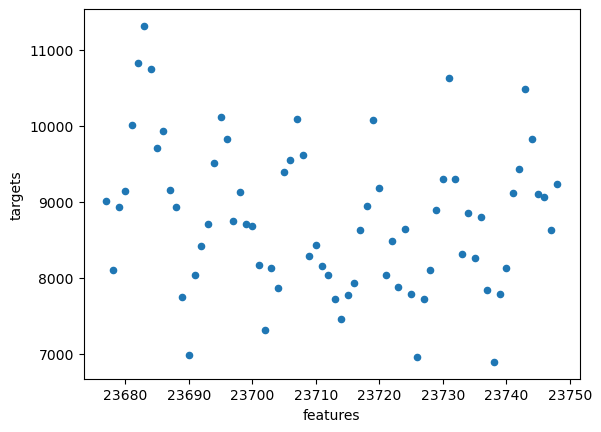

In [293]:
#plot
if olympics!=1:
    dataset['features']=dataset['features'].map(lambda x: int(x.split('-')[0])*12+int(x.split('-')[1]))
if dataset.shape[1]==2:
    dataset.plot.scatter(x='features',y='targets')

In [294]:
from ridge import Ridge_Regression
from sklearn.linear_model import Ridge
X=dataset.drop('targets',axis=1).values.reshape(-1,dataset.shape[1]-1)
Y=dataset['targets'].values.reshape(-1,1)
## given the low amount of data available we decided to do a K-fold cross validation
## the parameter lambda follows a coarse to fine approach
## the coarse search is done with a step of 0.1 and the fine search with a step of 0.01
lambda_values=np.linspace(0,90000000,num=(900+1))
k=5
fold_size=int(len(X)/k)
# generate the intervals for the coarse to fine approach from 1 to 10^-20
for subinterval in np.array(10.0 ** np.arange(6, -20, -1)):
    lambda_mses=[]
    print('subinterval: ',subinterval)
    for lambda_value in lambda_values:
        ridge=Ridge_Regression(lambda_value)
        mses=[]
        for i in range(k):
            # K-fold cross validation (take the data from the i-th fold as test data)
            Xi=np.concatenate((X[:i*fold_size],X[(i+1)*fold_size:]),axis=0)
            Yi=np.concatenate((Y[:i*fold_size],Y[(i+1)*fold_size:]),axis=0)
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i*fold_size:(i+1)*fold_size])
            mses.append(((Y[i*fold_size:(i+1)*fold_size]-y_pred)**2).mean())
        lambda_mses.append(np.mean(mses))
        print('lambda: ',lambda_value,' mse: ',np.mean(mses))
    print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
    lambda_values=np.linspace(max(lambda_values[np.argmin(lambda_mses)]-1*subinterval,0),lambda_values[np.argmin(lambda_mses)]+1*subinterval,num=(20+1))
lambda_value=lambda_values[np.argmin(lambda_mses)]

subinterval:  1000000.0
lambda:  0.0  mse:  1025848.1989466777
lambda:  100000.0  mse:  973293.0564820506
lambda:  200000.0  mse:  973292.6456514501
lambda:  300000.0  mse:  973292.2362742344
lambda:  400000.0  mse:  973291.8283515057
lambda:  500000.0  mse:  973291.4218834592
lambda:  600000.0  mse:  973291.0168701464
lambda:  700000.0  mse:  973290.6133115701
lambda:  800000.0  mse:  973290.2112077235
lambda:  900000.0  mse:  973289.8105585842
lambda:  1000000.0  mse:  973289.4113641346
lambda:  1100000.0  mse:  973289.0136243483
lambda:  1200000.0  mse:  973288.6173392035
lambda:  1300000.0  mse:  973288.2225086733
lambda:  1400000.0  mse:  973287.8291327327
lambda:  1500000.0  mse:  973287.4372113552
lambda:  1600000.0  mse:  973287.0467445174
lambda:  1700000.0  mse:  973286.6577321889
lambda:  1800000.0  mse:  973286.2701743454
lambda:  1900000.0  mse:  973285.884070961
lambda:  2000000.0  mse:  973285.4994220076
lambda:  2100000.0  mse:  973285.1162274592
lambda:  2200000.0  mse

In [295]:
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y)
if olympics==1:
    x=np.array([2010,2012,2014,2016,2018,2020]).reshape(-1,1)
else:
    x=(np.array([2010,2012,2014,2016,2018,2020])*12).reshape(-1,1)
y_pred=ridge.Predict(x.reshape(-1,1))
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(x.reshape(-1,1))
for i in range(len(X)):
    print('year: ',X[i],' time: ',Y[i])
for i in range(len(x)):
    print('year: ',x[i],' time: ',y_pred[i])
    print('scikit: year: ',x[i],' time: ',y_pred_sklearn[i])

year:  [23677]  time:  [9007]
year:  [23678]  time:  [8106]
year:  [23679]  time:  [8928]
year:  [23680]  time:  [9137]
year:  [23681]  time:  [10017]
year:  [23682]  time:  [10826]
year:  [23683]  time:  [11317]
year:  [23684]  time:  [10744]
year:  [23685]  time:  [9713]
year:  [23686]  time:  [9938]
year:  [23687]  time:  [9161]
year:  [23688]  time:  [8927]
year:  [23689]  time:  [7750]
year:  [23690]  time:  [6981]
year:  [23691]  time:  [8038]
year:  [23692]  time:  [8422]
year:  [23693]  time:  [8714]
year:  [23694]  time:  [9512]
year:  [23695]  time:  [10120]
year:  [23696]  time:  [9823]
year:  [23697]  time:  [8743]
year:  [23698]  time:  [9129]
year:  [23699]  time:  [8710]
year:  [23700]  time:  [8680]
year:  [23701]  time:  [8162]
year:  [23702]  time:  [7306]
year:  [23703]  time:  [8124]
year:  [23704]  time:  [7870]
year:  [23705]  time:  [9387]
year:  [23706]  time:  [9556]
year:  [23707]  time:  [10093]
year:  [23708]  time:  [9620]
year:  [23709]  time:  [8285]
year